In [2]:
# Preprocessing functions:
# Normal
# CLAHE
# OD+OC
# Grayscale
# Grayscale CLAHE

# Edge extracted
# Vein+artery


In [5]:
import numpy as np
import cv2
import os
from tqdm import tqdm

PROCESSED_DIR = "./processed_data"
INPUT_FILE = f"{PROCESSED_DIR}/fundus_images_full.npz"

# Output NPZ files
OUT_CLAHE = f"{PROCESSED_DIR}/fundus_images_CLAHE_full.npz"
OUT_GRAY = f"{PROCESSED_DIR}/fundus_images_gray_full.npz"
OUT_GRAY_CLAHE = f"{PROCESSED_DIR}/fundus_images_gray_CLAHE_full.npz"
OUT_EDGES = f"{PROCESSED_DIR}/fundus_images_edges_full.npz"

In [6]:
import cv2
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))

def apply_clahe_rgb(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    cl = clahe.apply(l)
    lab_cl = cv2.merge([cl, a, b])
    return cv2.cvtColor(lab_cl, cv2.COLOR_LAB2RGB)

def to_gray_rgb(img):
    g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.stack([g, g, g], axis=-1)

def gray_clahe_rgb(img):
    g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g_cl = clahe.apply(g)
    return np.stack([g_cl, g_cl, g_cl], axis=-1)

def edge_extract_rgb(img):
    g = cv2.cvtColor(gray_clahe_rgb(img), cv2.COLOR_RGB2GRAY)
    g = cv2.GaussianBlur(g, (5, 5), 1.0)
    edges = cv2.Canny(g, 40, 120)
    return np.stack([edges, edges, edges], axis=-1)

In [4]:

npz = np.load(INPUT_FILE, mmap_mode="r")
X = npz["X"]
name = npz["name"]
N = X.shape[0]

In [5]:

shape = X.shape
dtype = X.dtype

def create_memmap(path):
    return np.memmap(path, mode="w+", dtype=dtype, shape=shape)

m_clahe = create_memmap("tmp_CLAHE.dat")
m_gray = create_memmap("tmp_GRAY.dat")
m_gray_clahe = create_memmap("tmp_GRAY_CLAHE.dat")
m_edges = create_memmap("tmp_EDGES.dat")

for i in tqdm(range(N)):
    img = X[i]
    
    out1 = apply_clahe_rgb(img)
    out2 = to_gray_rgb(img)
    out3 = gray_clahe_rgb(img)
    out4 = edge_extract_rgb(img)
    
    m_clahe[i] = out1
    m_gray[i] = out2
    m_gray_clahe[i] = out3
    m_edges[i] = out4

# Flush to disk
m_clahe.flush()
m_gray.flush()
m_gray_clahe.flush()
m_edges.flush()

# -----------------------------------------------------------
# Store as NPZ, still RAM-friendly by streaming each memmap
# -----------------------------------------------------------
def write_npz(out_name, memmap_path):
    arr = np.memmap(memmap_path, mode="r", dtype=dtype, shape=shape)
    np.savez_compressed(out_name, X=arr, name=name)

write_npz(OUT_CLAHE, "tmp_CLAHE.dat")
write_npz(OUT_GRAY, "tmp_GRAY.dat")
write_npz(OUT_GRAY_CLAHE, "tmp_GRAY_CLAHE.dat")
write_npz(OUT_EDGES, "tmp_EDGES.dat")

# Optional cleanup
os.remove("tmp_CLAHE.dat")
os.remove("tmp_GRAY.dat")
os.remove("tmp_GRAY_CLAHE.dat")
os.remove("tmp_EDGES.dat")


100%|██████████████████████████████████████████████████████████████████████████████| 2805/2805 [00:22<00:00, 127.24it/s]


In [6]:
import numpy as np
from PIL import Image
import os

def crop_pad_square(img, center_y, center_x, crop_height, crop_width):
    H, W = img.shape[:2]

    y1 = int(center_y - crop_height // 2)
    x1 = int(center_x - crop_width // 2)
    y2 = y1 + crop_height
    x2 = x1 + crop_width

    pad_top    = max(0, -y1)
    pad_left   = max(0, -x1)
    pad_bottom = max(0, y2 - H)
    pad_right  = max(0, x2 - W)

    y1_clip = max(0, y1)
    y2_clip = min(H, y2)
    x1_clip = max(0, x1)
    x2_clip = min(W, x2)

    crop = img[y1_clip:y2_clip, x1_clip:x2_clip]

    if any([pad_top, pad_bottom, pad_left, pad_right]):
        crop = np.pad(
            crop,
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)) if img.ndim == 3 else
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode="constant",
            constant_values=0
        )

    return crop


def pad_to_square(arr):
    h, w = arr.shape[:2]
    if h == w:
        return arr

    max_dim = max(h, w)
    pad_h = (max_dim - h) // 2
    pad_w = (max_dim - w) // 2
    pad_h_extra = (max_dim - h) % 2
    pad_w_extra = (max_dim - w) % 2

    if arr.ndim == 3:
        return np.pad(
            arr,
            ((pad_h, pad_h + pad_h_extra),
             (pad_w, pad_w + pad_w_extra),
             (0, 0)),
            mode="constant",
            constant_values=0
        )
    else:
        return np.pad(
            arr,
            ((pad_h, pad_h + pad_h_extra),
             (pad_w, pad_w + pad_w_extra)),
            mode="constant",
            constant_values=0
        )


def resize_square(arr, size):
    pil = Image.fromarray(arr)
    pil = pil.resize((size, size), Image.Resampling.LANCZOS)
    return np.asarray(pil, dtype=np.uint8)


def ensure_disc_visible(center, disc_center, disc_radius, crop_half):
    margin = int(0.1 * disc_radius)
    min_c = disc_center - (crop_half - margin)
    max_c = disc_center + (crop_half - margin)
    return np.clip(center, min_c, max_c)


def generate_crops_square_extended(
    images_npz,
    masks_npz,
    od_out="./processed_data/crop_od.npz",
    vert_out="./processed_data/crop_vertical.npz",
    hm_out="./processed_data/crop_halfmoon.npz",
    od_size=224,
    vertical_size=224,
    halfmoon_size=224,
    scale_factor=1.75,
    vertical_shift_ratio=0.40,
    halfmoon_temporal_shift_ratio=2.0
):
    img_npz = np.load(images_npz, mmap_mode="r")
    mask_npz = np.load(masks_npz, mmap_mode="r")

    images = img_npz["X"]
    masks  = mask_npz["X"]
    names  = img_npz["name"]

    N = images.shape[0]
    C = images.shape[3] if images.ndim == 4 else 1
    H_img, W_img = images.shape[1], images.shape[2]

    od_mm   = np.memmap("tmp_od.dat", dtype=np.uint8, mode="w+", shape=(N, od_size, od_size, C))
    vert_mm = np.memmap("tmp_vert.dat", dtype=np.uint8, mode="w+", shape=(N, vertical_size, vertical_size, C))
    hm_mm   = np.memmap("tmp_hm.dat", dtype=np.uint8, mode="w+", shape=(N, halfmoon_size, halfmoon_size, C))

    for i in range(N):
        img = images[i]
        mask = masks[i]

        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask[:, :, 0]

        if mask.sum() == 0:
            od_mm[i] = 0
            vert_mm[i] = 0
            hm_mm[i] = 0
            continue

        rows, cols = np.where(mask > 0)
        cy = (rows.min() + rows.max()) / 2
        cx = (cols.min() + cols.max()) / 2

        od_diameter = max(rows.max() - rows.min(), cols.max() - cols.min())
        disc_radius = od_diameter / 2

        # ---- OD crop (unchanged) ----
        crop_size = int(od_diameter * scale_factor)
        od_crop = crop_pad_square(img, cy, cx, crop_size, crop_size)
        od_mm[i] = resize_square(od_crop, od_size)

        # ---- Vertical crop ----
        vert_crop_height = int(0.8 * H_img)
        vert_crop_width  = int(0.35 * W_img)

        vert_cx = cx + vertical_shift_ratio * ((W_img / 2) - cx)


        vert_crop = crop_pad_square(
            img, cy, vert_cx,
            vert_crop_height, vert_crop_width
        )
        vert_mm[i] = resize_square(
            pad_to_square(vert_crop),
            vertical_size
        )

        # ---- Half-moon crop (fixed size, temporal ----
        hm_crop_height = int(0.65 * H_img)
        hm_crop_width  = int(0.6 * W_img)

        hm_cx = cx + halfmoon_temporal_shift_ratio * ((W_img / 2) - cx)


        hm_crop = crop_pad_square(
            img, cy, hm_cx,
            hm_crop_height, hm_crop_width
        )
        hm_mm[i] = resize_square(
            pad_to_square(hm_crop),
            halfmoon_size
        )

    od_mm.flush()
    vert_mm.flush()
    hm_mm.flush()

    np.savez(od_out, X=od_mm, name=names)
    np.savez(vert_out, X=vert_mm, name=names)
    np.savez(hm_out, X=hm_mm, name=names)

    os.remove("tmp_od.dat")
    os.remove("tmp_vert.dat")
    os.remove("tmp_hm.dat")

    return od_out, vert_out, hm_out

In [10]:
od_out, vert_out, hm_out = generate_crops_square_extended(
    "./processed_data/fundus_images_full.npz",
    "./od_oc_masks.npz",
)

data_od = np.load(od_out)
data_vert = np.load(vert_out)
data_hm = np.load(hm_out)

X_od = data_od["X"]
X_vert = data_vert["X"]
X_hm = data_hm["X"]

print(X_od.shape, X_vert.shape, X_hm.shape)


(2805, 224, 224, 3) (2805, 224, 224, 3) (2805, 224, 224, 3)


In [10]:
masks_dict = np.load("./od_oc_masks.npz")
masks = masks_dict['X']


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

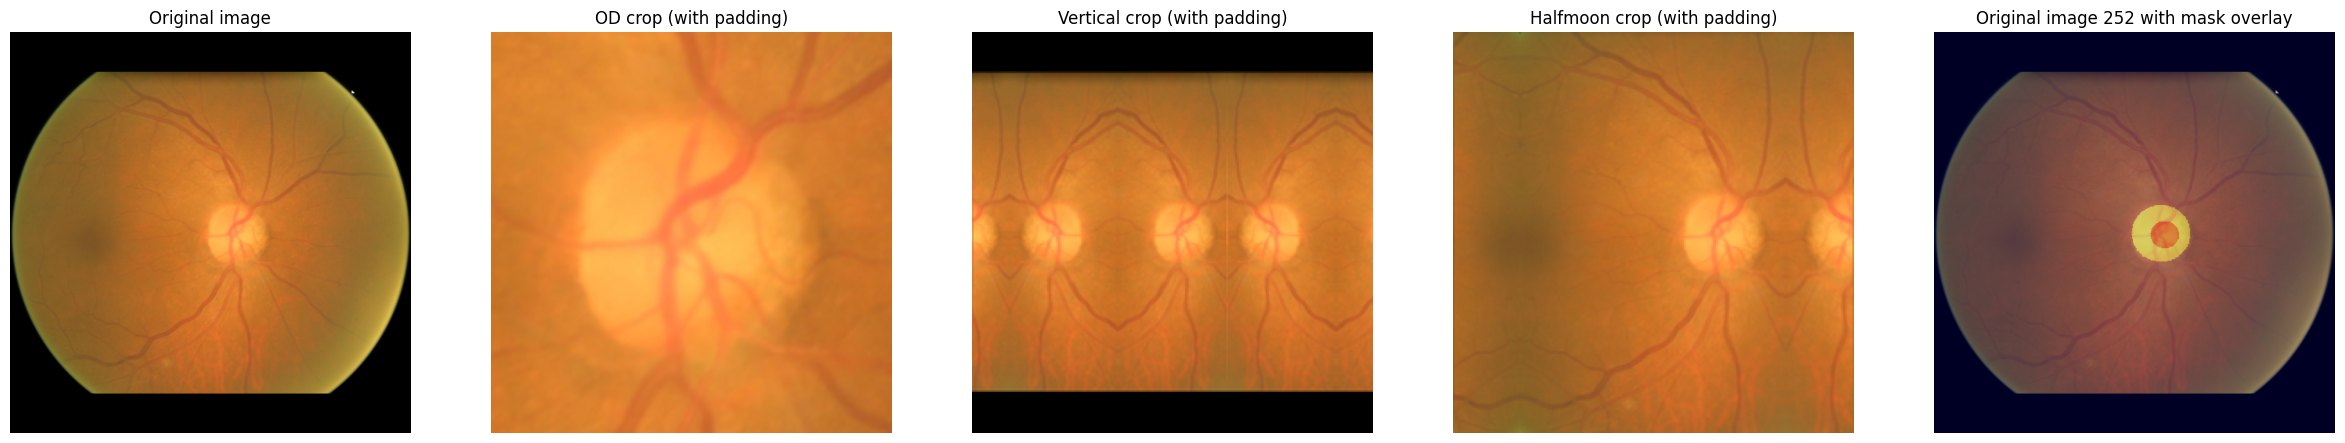

In [106]:
idx = 252

od_image = X_od[idx]
vertical_image = X_vert[idx]
halfmoon_image = X_hm[idx]
full_image = X[idx]
mask = masks[idx]

# If mask has extra channel dimension, remove it
if mask.ndim == 3 and mask.shape[2] == 1:
    mask = mask.squeeze()

# Normalize mask to [0,1]
mask_norm = mask / mask.max()

import numpy as np
import matplotlib.pyplot as plt

num_images = 5
plt.figure(figsize=(6*num_images, 6))

plt.subplot(1, num_images, 1)
plt.imshow(full_image)
plt.axis('off')
plt.title("Original image")

plt.subplot(1, num_images, 2)
plt.imshow(od_image)
plt.axis('off')
plt.title("OD crop (with padding)")

plt.subplot(1, num_images, 3)
plt.imshow(vertical_image)
plt.axis('off')
plt.title("Vertical crop (with padding)")

plt.subplot(1, num_images, 4)
plt.imshow(halfmoon_image)
plt.axis('off')
plt.title("Halfmoon crop (with padding)")

# 3. Original + mask
plt.subplot(1, num_images, 5)
plt.imshow(full_image)
plt.imshow(mask_norm, cmap='jet', alpha=0.3)
plt.title(f"Original image {idx} with mask overlay")
plt.axis('off')


In [7]:
processed_data_identifiers = ["", "_CLAHE", "_edges", "_gray_CLAHE", "_gray"]

for identifier in processed_data_identifiers:
    print(f"Beginning cropping for {identifier}...")
    if identifier == "":
        out_identifier = "_normal"
    else:
        out_identifier = identifier
        
    od_out, vert_out, hm_out = generate_crops_square_extended(
        f"./processed_data/fundus_images{identifier}_full.npz",
        "./od_oc_masks.npz",
        od_out=f"./processed_data/fundus_images{out_identifier}_od.npz",
        vert_out=f"./processed_data/fundus_images{out_identifier}_vert.npz",
        hm_out=f"./processed_data/fundus_images{out_identifier}_hm.npz",
    )

Beginning cropping for ...
Beginning cropping for _CLAHE...
Beginning cropping for _edges...
Beginning cropping for _gray_CLAHE...
Beginning cropping for _gray...


In [7]:
od_edges_dict = np.load("./processed_data/fundus_images_od.npz")
vert_edges_dict = np.load("./processed_data/fundus_images_vert.npz")
hm_edges_dict = np.load("./processed_data/fundus_images_hm.npz")
full_edges_dict = np.load("./processed_data/fundus_images_full.npz")

X_od = od_edges_dict['X']
X_vert = vert_edges_dict['X']
X_hm = hm_edges_dict['X']
X = full_edges_dict['X']

FileNotFoundError: [Errno 2] No such file or directory: './processed_data/fundus_images_od.npz'

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

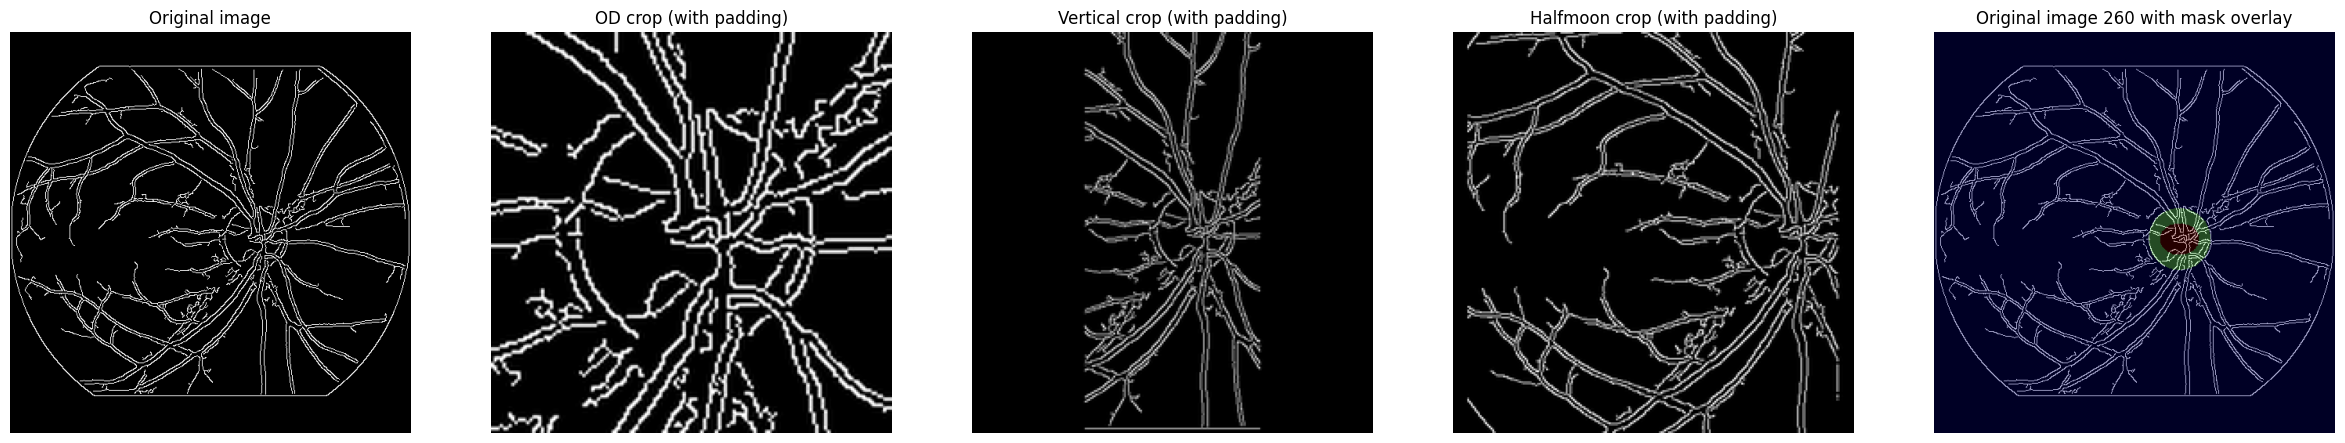

In [11]:
idx = 260

od_image = X_od[idx]
vertical_image = X_vert[idx]
halfmoon_image = X_hm[idx]
full_image = X[idx]
mask = masks[idx]

# If mask has extra channel dimension, remove it
if mask.ndim == 3 and mask.shape[2] == 1:
    mask = mask.squeeze()

# Normalize mask to [0,1]
mask_norm = mask / mask.max()

import numpy as np
import matplotlib.pyplot as plt

num_images = 5
plt.figure(figsize=(6*num_images, 6))  # keep square-ish per image

plt.subplot(1, num_images, 1)
plt.imshow(full_image)
plt.axis('off')
plt.title("Original image")

plt.subplot(1, num_images, 2)
plt.imshow(od_image)
plt.axis('off')
plt.title("OD crop (with padding)")

plt.subplot(1, num_images, 3)
plt.imshow(vertical_image)
plt.axis('off')
plt.title("Vertical crop (with padding)")

plt.subplot(1, num_images, 4)
plt.imshow(halfmoon_image)
plt.axis('off')
plt.title("Halfmoon crop (with padding)")

# 3. Original + mask
plt.subplot(1, num_images, 5)
plt.imshow(full_image)
plt.imshow(mask_norm, cmap='jet', alpha=0.3)
plt.title(f"Original image {idx} with mask overlay")
plt.axis('off')
